---
<h1><center>Chicago Food Inspection: Experimentation with Statistical Significance</center></h1>
<h3><center>By: Greg Araya</center></h3>


---

Recently I decided to perform a small study that shows the importance of using statistical significance tests before making decisions based on perceived patterns. Since I live in Chicago, I thought it would be interesting to do some data analysis on some real data about my city. In the report below, I analyze a public data set produced by the city of Chicago that has information about food inspection outcomes from 2010 and on. I will use this to show what incorrect assumptions could be gleaned by the lazy eye, as well as prove why those initial reactions are incorrect. To accomplish this, I will first look through the data set to find something that provokes a reaction. Following this, I will come up with some hypotheses about this data and perform statistical significance tests on them. If you are interested in looking at the raw data set, I have provided a link to the Kaggle page here.

Data set: https://www.kaggle.com/chicago/chicago-food-inspections/version/166

Now, let's take a look at the data!

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import scipy
from scipy import stats
import math
%matplotlib inline

In [2]:
main_df = pd.read_csv('food-inspections.csv')    # Read in the CSV file
main_df.head(4)                                  # Display the first few rows

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,...,Results,Violations,Latitude,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards
0,2291007,DOLLAR TREE #06910,DOLLAR TREE #06910,2658583.0,Grocery Store,Risk 3 (Low),11037-11043 S KEDZIE AVE,CHICAGO,IL,60655.0,...,Fail,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,41.692286,-87.700704,"{'latitude': '41.69228559655915', 'human_addre...",33.0,4447.0,73.0,256.0,42.0
1,2291036,PICNIC WINE & PROVISIONS,PICNIC WINE & PROVISIONS,2636701.0,Restaurant,Risk 2 (Medium),7301 N SHERIDAN RD,CHICAGO,IL,60626.0,...,Fail,NaN,42.014041,-87.663971,"{'latitude': '42.0140411322766', 'human_addres...",3.0,21853.0,10.0,357.0,5.0
2,2291030,ICE CREAM BAR INC.,ICE CREAM BAR,2665087.0,Restaurant,Risk 2 (Medium),3725 W CHICAGO AVE,CHICAGO,IL,60651.0,...,Pass,43. IN-USE UTENSILS: PROPERLY STORED - Comment...,41.895317,-87.719910,"{'latitude': '41.895317295733214', 'human_addr...",41.0,4299.0,24.0,584.0,46.0
3,2291013,MARTINI CLUB,MARTINI CLUB,76170.0,Restaurant,Risk 1 (High),5737 W IRVING PARK RD,CHICAGO,IL,60634.0,...,Out of Business,NaN,41.953020,-87.770968,"{'latitude': '41.95302030864294', 'human_addre...",25.0,22254.0,15.0,311.0,19.0


Looking over this quickly, it seems that the city of Chicago has gone into great detail about each and every inspection that has been performed. They have included the names of the locations, the licenses and ID numbers, the type of facility, the address, the outcome of the inspection, precise details about any violations, and more, even down to the latitude and longitude of each establishment. Since I have lived in a few places in Chicago and love to go out to eat I started thinking to myself, I wonder what the breakdown of failed inspections look like in each neighborhood. So let's pull out all the data about failed inspections and plot these points out using the provided latitude and longitude values. Below, each dot represents a failed inspection at that address, and the color of each dot represents the number of failed inspections that were cited in the zip code that the establishment is in.

In [3]:
chicago_img=mpimg.imread('Chicago_clean2.png')

# Set up a new dataframe and drop rows with empty zip code values and/or latitude/longitute values
chi_df = main_df[main_df['Zip'].notnull()].copy()
chi_df = chi_df[chi_df['Latitude'].notnull()].copy()
chi_df = chi_df[chi_df['Longitude'].notnull()].copy()

# Set the zip codes to integers to get rid of the decimal
chi_df.loc[:,'Zip'] = chi_df.loc[:,'Zip'].astype(int)

# Only include the failures
chi_df = chi_df[chi_df['Results'] == 'Fail']

# Add a column that shows how many times each zip code shows up
chi_df['# of Failures per Zip Code'] = chi_df.groupby('Zip')['Zip'].transform('count')

# Set the fail count to integers to let us heat map it
chi_df.loc[:,'# of Failures per Zip Code'] = chi_df.loc[:,'# of Failures per Zip Code'].astype(int)

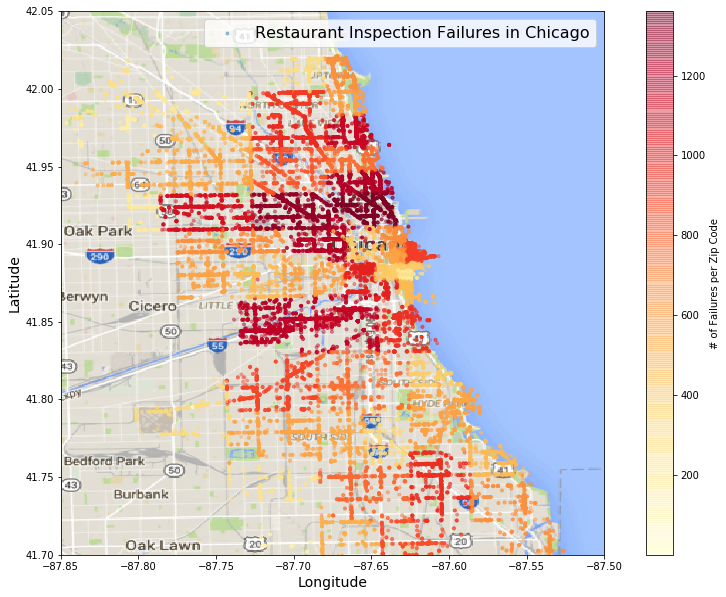

In [4]:
# Set up the plot and labels
ax = chi_df.plot(kind="scatter", x="Longitude", y="Latitude", figsize=(15,10),
                       s=9,
                       label="Restaurant Inspection Failures in Chicago",
                       c='# of Failures per Zip Code', cmap=plt.get_cmap("YlOrRd"),
                       colorbar=True, sharex=False, alpha=.4)

plt.imshow(chicago_img, extent=[-87.85, -87.5, 41.7, 42.05], alpha=1)

plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.legend(fontsize=16)
plt.show()

The colors above give an indication of the number of failed inspections each zip code has received, with the deeper reds showing the higher number of failures. Each dot shows us where each failure occurred. I was surprised that a lot of the neighborhoods appearing with darker shades of red are actually quite well known for having good restaurants. How often do restaurants fail their inspections? Should I be worried going to these areas? Is the quality of food in certain zip codes just false hype? Let's take a look at the breakdown of passes, failures, and everything in between.

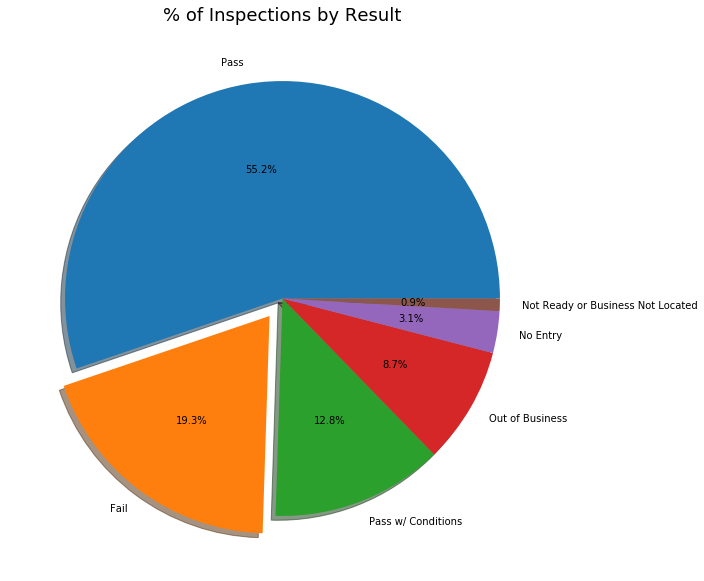

The total number of failed inspections is: 36270


In [5]:
# Let's start a new dataframe to play with just the results
res_df = main_df['Results']
res_df = res_df.to_frame()

# We also want to consolidate two pieces since they're so small they barely show up on the chart otherwise
res_df['Results'] = res_df['Results'].str.replace('Not Ready', 'NR or BNL')
res_df['Results'] = res_df['Results'].str.replace('Business Not Located', 'NR or BNL')

# Then we can count up the values, set it back to a dataframe, and get percentages
res_df = res_df['Results'].value_counts()
res_df = res_df.to_frame()
res_df['Results'] = res_df['Results'] / len(main_df)

# Create a list of labels for the pie chart
label_list = ['Pass', 'Fail', 'Pass w/ Conditions', 'Out of Business', 'No Entry', 'Not Ready or Business Not Located']

exp = (0, 0.1, 0, 0, 0, 0)                       # above: list of days // this line: choose the slice to pull out

plt.figure(figsize=(10,10))                         # set the size of the figure so it is more readable
plt.pie(
    res_df['Results'],                              # grab counts
    labels=label_list,                              # label it
    autopct='%1.1f%%',                              # set digits of percentages
    explode=exp,                                    # pull out the chosen slice
    shadow=True)                                    # set a shadow behind the slices

plt.title('% of Inspections by Result', fontsize=18)    # create a title
plt.rcParams["axes.labelweight"] = "bold"               # bold the text for readability
plt.show()                                              # plot away

# Let's also get a total number of failures for reference
fails = len(main_df[main_df['Results'] == 'Fail'])
print("The total number of failed inspections is: " + str(fails))

OK, so it looks like locations are given a failing verdict just under 20% of the time. That's not very heart warming to think about. Granted, just because a place fails an inspection doesn't mean that it gets shut down, but if you had two seemingly equivalent restaurants to choose from and only one of them had at some point failed an inspection, which would you choose to go to?

To put these numbers under a different light, this data has been taken since January of 2010 and was last updated 6/7/2019 (as of this writing). In that time period 36,270 failed inspections have been recorded within just a little over 9 years, which works out to a rate of approximately 4,030 failed inspections per year. That seems like a lot, but the point that I'm working up to here is that these numbers most likely just LOOK scary. Chicago is a massive city after all. To build on this, let's look at each specific zip code on their own.

When exploring the column of zip codes earlier I found there were missing values, so let's create a new dataframe that only has rows where the zip code exists. Then I will calculate the statistics for each zip code and print out the important figures to some tables.

In [6]:
# Drop rows with empty zip code values so we have a set of data with all zip codes included
zip_df = main_df[main_df['Zip'].notnull()].copy()

# Set the zip codes to integers to get rid of the decimal
zip_df.loc[:,'Zip'] = zip_df.loc[:,'Zip'].astype(int)

# Create a set of all the fails in each zip code counted up
fail_zips = zip_df[zip_df['Results'] == 'Fail']['Zip'].value_counts()

# Sort this failure zip code dataset by the number of failures
fail_zips = fail_zips.to_frame().sort_values(by=['Zip'], ascending=False)
fail_zips.columns = ['Number of Failures']

# Print it out
fail_zips.head(10)

,Number of Failures
60614,1361
60647,1303
60657,1214
60622,1210
60623,1183
60608,1167
60640,1146
60639,1081
60607,995
60625,964


The table above is displaying the top 10 zip codes when counting just the raw number of failures. However, if you think about it a bit, this could turn out to be the case because there are so many restaurants in those areas. Before we demonize them let's see what the top 10 areas are when sorted by total number of inspections.

In [7]:
# Create a set from the data frame of all the zip codes counted up
all_zips = zip_df['Zip'].value_counts()
all_zips = all_zips.to_frame()
all_zips.columns = ['Number of Inspections']

# Merge this data with the Number of failures by zip code 
zips_info = all_zips.merge(fail_zips, left_index=True, right_index=True)

# Sort by the number of inspections
zips_info = zips_info.sort_values(by=['Number of Inspections'], ascending=False)

# Print it out
zips_info.head(10)

,Number of Inspections,Number of Failures
60614,7084,1361
60647,6727,1303
60657,6522,1214
60611,5894,899
60622,5862,1210
60618,5716,830
60608,5704,1167
60625,5126,964
60639,5020,1081
60640,4978,1146


Again I've printed out the top 10 zip codes, but this time they are sorted by the total number of inspections. Notice how most of these zip codes are in the same or similar spots in both outputs. This shows that it's possible these areas may just SEEM to be more prone to inspection failures at first glance, but may not be so different in reality. Let's perform a statistical significance test on zip code 60614 since it is the #1 in terms of number of inspections as well as number of failures, to determine if I should ever eat there again.

### A binomial test on the 60614 zip code vs. the rest of the data set, with a significance level of p < 0.05:

### -- Hypothesis: Restaurants in zip code 60614 are more likely to FAIL health inspections.


### -- Null Hypothesis: Restaurants in zip code 60614 are just as likely to FAIL health inspections as restaurants in other zip codes.

In [8]:
# Statistics of data without 60614
null_set = zips_info[1:]

# Statistics of data for 60614
hypo_set = zips_info[:1]

# Stats needed to perform test
null_avg = null_set['Number of Failures'].sum() / null_set['Number of Inspections'].sum()
hypo_fails = hypo_set['Number of Failures'].sum()
hypo_total = hypo_set['Number of Inspections'].sum()

# Perform binomial test
bi_stat = scipy.stats.binom_test(hypo_fails, hypo_total, null_avg, alternative='greater')

print("We arrive at a p value of: " + str(bi_stat))

We arrive at a p value of: 0.565438499728204


Our calculated p value of 0.5654 is greater than our established significance level of 0.05 and therefore we fail to reject the null hypothesis. This outcome dictates then that it is most likely safe to eat in the 60614 neighborhood! Or at least, it is not any worse than the average quality of food in the city of Chicago. To make this point even more clear, we can also look at the success rates of the 60614 zip code in relation to the rest of the data. I'll start this process by again creating two "Top 10" tables that show the top 10 zip codes with respect to number of passes, and then with respect to number of total inspections in each zip code.

In [9]:
# Create a set of all the passes in each zip code counted up
pass_zips = zip_df[zip_df['Results'] == 'Pass']['Zip'].value_counts()

# Sort this failure zip code dataset by the number of failures
pass_zips = pass_zips.to_frame().sort_values(by=['Zip'], ascending=False)
pass_zips.columns = ['Number of Passes']

# Print it out
pass_zips.head(10)

,Number of Passes
60611,3587
60647,3515
60614,3456
60657,3333
60618,3283
60622,3253
60608,3077
60607,2797
60625,2655
60616,2640


In [10]:
# Merge this data with the Number of passes by zip code 
pass_info = all_zips.merge(pass_zips, left_index=True, right_index=True)

# Sort by the number of inspections
pass_info = pass_info.sort_values(by=['Number of Inspections'], ascending=False)

# Print it out
pass_info.head(10)

,Number of Inspections,Number of Passes
60614,7084,3456
60647,6727,3515
60657,6522,3333
60611,5894,3587
60622,5862,3253
60618,5716,3283
60608,5704,3077
60625,5126,2655
60639,5020,2631
60640,4978,2429


Looking at the two "Top 10" tables above, you'll notice again that a good number of the same zip codes are showing up from the last time. Zip code 60614 is high up in the rankings again, so I'll perform another binomial test on the pass rate of this zip code.

### A binomial test on the 60614 zip code vs. the rest of the data set, with a significance level of p < 0.05:

### -- Hypothesis: Restaurants in zip code 60614 are more likely to PASS health inspections.


### -- Null Hypothesis: Restaurants in zip code 60614 are just as likely to PASS health inspections as restaurants in other zip codes.

In [11]:
# Statistics of data without 60614
p_null_set = pass_info[1:]

# Statistics of data for 60614
p_hypo_set = pass_info[:1]

# Stats needed to perform test
p_null_avg = p_null_set['Number of Passes'].sum() / p_null_set['Number of Inspections'].sum()
p_hypo_pass = p_hypo_set['Number of Passes'].sum()
p_hypo_total = p_hypo_set['Number of Inspections'].sum()

# Perform binomial test
bi_stat_2 = scipy.stats.binom_test(p_hypo_pass, p_hypo_total, p_null_avg, alternative='greater')

print("We arrive at a p value of: " + str(bi_stat_2))

We arrive at a p value of: 0.9999999999999999


Once again, our calculated p value is greater than our established significance level of 0.05 (this time far greater) and therefore we fail to reject the null hypothesis. So it looks like an establishment in the zip code 60614 is just as likely to pass or fail as any other place. In fact, if you calculate out the actual average (which I have done below) it matches the average that we discovered in the pie chart above almost exactly.

In [12]:
avg = pass_info['Number of Passes'].sum() / pass_info['Number of Inspections'].sum()

print("The average passing rate of restaurants in the 60614 area is: " + str(avg))

The average passing rate of restaurants in the 60614 area is: 0.5522042010103696


So at the end of it all, what have we learned?


Looking at just the raw numbers, such as number of failures or successes, won't always tell you the full story. In order to be certain that your ideas about a data set are correct, one must complete an appropriate statistical significance test. Otherwise any pattern or behavior that you may think you are witnessing may be completely incorrect and lead to erroneous analysis. This could then lead into bad decision making, or the spread of false information, and perpetuate from there affecting others.